# Simple Models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, classification_report, f1_score, fbeta_score, make_scorer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.compose import make_column_transformer
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as imb_pipeline




pd.set_option('display.float_format', lambda x: '%.2f' % x)
RSEED = 42

In [2]:
# df = pd.read_csv('data/cleaned/train.csv')
# df_test = pd.read_csv('data/cleaned/test.csv')
df = pd.read_csv('data/cleaned/train_extended.csv')
df_test = pd.read_csv('data/cleaned/test_extended.csv')
df.head()


,district,client_id,client_catg,region,reading_remarque_6,reading_remarque_7,reading_remarque_8,reading_remarque_9,reading_remarque_413,counter_statue_0,...,counter_coefficient_30,counter_coefficient_33,counter_coefficient_40,counter_coefficient_50,counter_code_count_unique,counter_number_count_unique,counter_type_count_unique,months_number,consommation_sum,target
0,60,train_Client_29310,11,101,18,0,6,34,0,56,...,0,0,0,0,2,3,2,3.93,734.81,0.00
1,63,train_Client_128477,11,312,1,0,2,1,0,4,...,0,0,0,0,1,1,1,3.50,325.75,0.00
2,63,train_Client_56966,11,311,40,0,15,23,0,78,...,0,0,0,0,2,2,2,4.21,537.35,0.00
3,69,train_Client_23694,11,104,0,0,3,17,0,20,...,0,0,0,0,2,2,2,4.00,762.45,0.00
4,62,train_Client_12064,11,309,2,0,0,24,0,26,...,0,0,0,0,2,2,2,4.00,375.73,0.00


## Split Target, Drop ID

In [3]:
y_train = df['target']
X_train = df.drop(['target', 'client_id'], axis=1)

In [4]:
#Split target from test data
y_test = df_test['target']
X_test = df_test.drop(['target', 'client_id'], axis=1)

## Feature Engineering

#### ColumnTransformer

In [5]:
# numerical features
num_features = [ 'consommation_sum', 'months_number']
num_transformer = make_pipeline(
        MinMaxScaler(), # no gaussian distribution? 
        # StandardScaler()
    )

In [6]:
preprocessor = make_column_transformer(
        (num_transformer, num_features)
)

## Imbalanced Data

### Random Oversampler

In [7]:
# handling the imbalanced
ros = RandomOverSampler(random_state=RSEED)
X_train, y_train = ros.fit_resample(X_train, y_train)



### Undersampling

In [8]:
# # # SMOTE + ENN (Noise Reduction)
# smote_enn = SMOTEENN(random_state=42)

# X_train, y_train = smote_enn.fit_resample(X_train, y_train)


<Axes: xlabel='target', ylabel='count'>

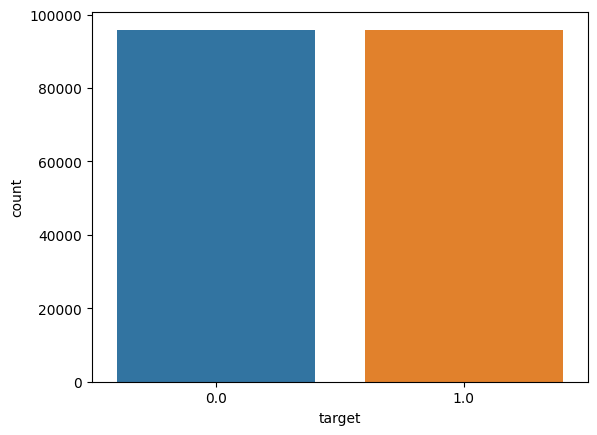

In [9]:
sns.countplot(x=y_train)

## Model Pipelines

In [ ]:
pipe_logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(random_state=RSEED))]
)

pipe_class = Pipeline([
    ('preprocessor', preprocessor),
    ('class', SGDClassifier(random_state=RSEED))]
)

pipe_knn = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier())]
)

pipe_tree = Pipeline([
    # ('preprocessor', preprocessor),
    ('tree', DecisionTreeClassifier(random_state=RSEED))]
)

### GridSearch & Model

In [10]:
# scoring = make_scorer(fbeta_score, beta=2)
scoring = 'roc_auc'
cv = 5 #RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)


### Logistic Regression

In [ ]:
param_logreg = {'logreg__penalty':('l1','l2'),
                'logreg__C': [0.001, 0.01, 0.1, 1, 10],
                'logreg__solver': ['liblinear', 'lbfgs', 'sag'],
                'logreg__max_iter' : [1000, 500]
               }

grid_logreg = GridSearchCV(pipe_logreg, param_grid=param_logreg, cv=cv, scoring=scoring, 
                           verbose=5, n_jobs=-1) #evt. add error_score='raise'

In [ ]:
grid_logreg.fit(X_train, y_train)

In [ ]:
# Show best parameters
print('Best score:\n{:.2f}'.format(grid_logreg.best_score_))
print("Best parameters:\n{}".format(grid_logreg.best_params_))

In [ ]:
# Save best model (including fitted preprocessing steps) as best_model_logreg 
best_model_logreg = grid_logreg.best_estimator_
best_model_logreg

In [ ]:
y_test_predicted_logreg = best_model_logreg.predict(X_test)
y_test_proba_logreg = best_model_logreg.predict_proba(X_test)[:, 1]

print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted_logreg)))
print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted_logreg)))
print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted_logreg)))
print(f'Test ROC AUC Score: {roc_auc_score(y_test, y_test_proba_logreg)}')

### SGDClassifier

In [ ]:
sgdclass= SGDClassifier()
sgdclass.get_params()

In [ ]:
param_class = {'class__penalty':('l1','l2'),
                'class__alpha': [0.001, 0.01, 0.1, 1, 10],
                'class__learning_rate': ['optimal', 'constant', 'invscaling'],
                'class__loss': ['log_loss', 'modified_huber'],
                'class__max_iter' : [1000, 500],
                'class__eta0': [0.001, 0.01]
               }

grid_class = GridSearchCV(pipe_class, param_grid=param_class, cv=cv, scoring=scoring, 
                           verbose=5, n_jobs=-1) #evt. add error_score='raise'

In [ ]:
grid_class.fit(X_train, y_train)

In [ ]:
# Show best parameters
print('Best score:\n{:.2f}'.format(grid_class.best_score_))
print("Best parameters:\n{}".format(grid_class.best_params_))

In [ ]:
# Save best model (including fitted preprocessing steps) as best_model_class
best_model_class = grid_class.best_estimator_
best_model_class

In [ ]:
y_test_predicted_class = best_model_class.predict(X_test)
y_test_proba_class = best_model_class.predict_proba(X_test)[:, 1]


print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted_class)))
print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted_class)))
print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted_class)))
print(f'Test ROC AUC Score: {roc_auc_score(y_test, y_test_proba_class)}')

### KNN

In [ ]:
### KNN
# param_knn = {"knn__n_neighbors" : np.arange(2,50), #this actually defines the model you use
#               "knn__weights" : ["uniform", "distance"],
#               "knn__p" : [1, 2, 3],
#               "knn__algorithm": ["ball_tree", "kd_tree", "brute"]
#                }
param_knn = {"knn__n_neighbors" : np.arange(2,50), #this actually defines the model you use
              "knn__p" : [1, 2],
               }
             
grid_knn = GridSearchCV(pipe_knn, param_grid=param_knn, cv=cv, scoring=scoring, 
                           verbose=5, n_jobs=-1) #evt. add error_score='raise'
grid_knn.fit(X_train, y_train)



In [ ]:
# Show best parameters
print('Best score:\n{:.2f}'.format(grid_knn.best_score_))
print("Best parameters:\n{}".format(grid_knn.best_params_))


In [ ]:
# Save best model (including fitted preprocessing steps) as best_model_knn
best_model_knn = grid_knn.best_estimator_
best_model_knn


In [ ]:
y_test_predicted_knn = best_model_knn.predict(X_test)
y_test_proba_knn = best_model_knn.predict_proba(X_test)[:, 1]


print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted_knn)))
print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted_knn)))
print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted_knn)))
print(f'Test ROC AUC Score: {roc_auc_score(y_test, y_test_proba_knn)}')

### Decision Tree


In [ ]:
param_tree = {
    'tree__max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'tree__min_samples_split': [2, 5, 10],
    'tree__max_depth': [None] + list(np.arange(3, 10).astype(int)),
               }
             
grid_tree = GridSearchCV(pipe_tree, param_grid=param_tree, cv=cv, scoring=scoring, 
                           verbose=5, n_jobs=-1) #evt. add error_score='raise'
grid_tree.fit(X_train, y_train)



In [ ]:
# Show best parameters
print('Best score:\n{:.2f}'.format(grid_tree.best_score_))
print("Best parameters:\n{}".format(grid_tree.best_params_))


In [ ]:
# Save best model (including fitted preprocessing steps) as best_model_tree
best_model_tree = grid_tree.best_estimator_
best_model_tree


In [ ]:
y_test_predicted_tree = best_model_tree.predict(X_test)
y_test_proba_tree = best_model_tree.predict_proba(X_test)[:, 1]


print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted_tree)))
print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted_tree)))
print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted_tree)))
print(f'Train ROC AUC Score: {roc_auc_score(y_test, y_test_proba_tree)}')

### Decision Tree Without GridSearch ( = Baseline)

In [8]:
baseline_tree = DecisionTreeClassifier(random_state=RSEED, max_depth=7)
baseline_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, random_state=42)

In [9]:
y_test_predicted_bl = baseline_tree.predict(X_test)
y_test_proba_bl = baseline_tree.predict_proba(X_test)[:, 1]


print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted_bl)))
print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted_bl)))
print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted_bl)))
print(f'Train ROC AUC Score: {roc_auc_score(y_test, y_test_proba_bl)}')

Accuracy: 0.79
Recall: 0.76
Precision: 0.18
Train ROC AUC Score: 0.8372368600753054


In [10]:
# Compute FPR and TPR for the model to plot the roc_curve
fpr_values_dt, tpr_values_dt, _ = roc_curve(y_test, y_test_proba_bl)  # Probability of class 1
np.save("fpr_values_dt.npy", fpr_values_dt)
np.save("tpr_values_dt.npy", tpr_values_dt)

In [13]:
dt_metrics = np.array([accuracy_score(y_test, y_test_predicted_bl), precision_score(y_test, y_test_predicted_bl), recall_score(y_test, y_test_predicted_bl), f1_score(y_test, y_test_predicted_bl)]).round(2)
dt_metrics

array([0.79, 0.18, 0.76, 0.29])

### Output

In [ ]:
index = ['logreg', 'classifier', 'knn', 'tree', 'baseline_tree']
best_score_sum = [grid_logreg.best_score_, grid_class.best_score_, grid_knn.best_score_, grid_tree.best_score_, 'nan']
test_accuracy_sum = [accuracy_score(y_test, y_test_predicted_logreg), accuracy_score(y_test, y_test_predicted_class), accuracy_score(y_test, y_test_predicted_knn), accuracy_score(y_test, y_test_predicted_tree), accuracy_score(y_test, y_test_predicted_bl)]
test_recall_sum = [recall_score(y_test, y_test_predicted_logreg), recall_score(y_test, y_test_predicted_class), recall_score(y_test, y_test_predicted_knn),recall_score(y_test, y_test_predicted_tree), recall_score(y_test, y_test_predicted_bl)]
test_precision_sum = [precision_score(y_test, y_test_predicted_logreg), precision_score(y_test, y_test_predicted_class), precision_score(y_test, y_test_predicted_knn), precision_score(y_test, y_test_predicted_tree), precision_score(y_test, y_test_predicted_bl)]
test_roc_auc_sum = [roc_auc_score(y_test, y_test_proba_logreg), roc_auc_score(y_test, y_test_proba_class), roc_auc_score(y_test, y_test_proba_knn), roc_auc_score(y_test, y_test_proba_tree), roc_auc_score(y_test, y_test_proba_bl)]
output = pd.DataFrame({
    'model': index,
    'best_score': best_score_sum,
    'accuracy': test_accuracy_sum,
    'recall': test_recall_sum,
    'precision': test_precision_sum,
    'roc_auc': test_roc_auc_sum
})

output

**Undersampling**,
**own scorer**

|model|best_score|accuracy|recall|precision|roc_auc|
|---|---|---|---|---|---|
|    logreg|        0.87|    0.06|1.00|0.06|0.51|
|    classifier|    0.87|    0.06|1.00|0.06|0.51|
|    knn|            0.83|    0.47|0.73|0.07|0.62|
|    tree|        0.88|    0.27|0.90|0.07|0.57|
|    baseline_tree|nan|        0.61|0.77|0.10|0.76|

**Oversampling, own scorer**

|model|best_score|accuracy|recall|precision|roc_auc|
|---|---|---|---|---|---|
|logreg|0.65|0.43|0.58|0.06|0.51|
|classifier|0.83|0.06|1.00|0.06|0.50|
|knn|0.98|0.90|0.07|0.08|0.52|
|tree|0.99|0.90|0.07|0.07|0.50|
|baseline_tree|nan|0.79|0.76|0.18|0.84|